Import necessary librairies

In [1]:
import sys
import os
import time
import numpy as np
import pandas as pd
import warnings
import healpy as hp
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

path_folder = os.path.dirname(os.path.abspath("__file__"))
sys.path.insert(0,path_folder+'/../debvader/')
import cutout_img_dc2

import FoFCatalogMatching
import GCRCatalogs
import lsst.geom
import lsst.daf.persistence as dafPersist

### Generate a field image from DC2 simulation

Set parameters for generation.

In [2]:
tract = 4855 # Tract number selected for image generation
N = 1 # Number of images to generate
mag_cut = 24.5 # cut in magnitude

imsize = 259

img = np.zeros((N,imsize,imsize,6)) # initialise the image array
filters = ['u','g','r','i','z','y']

Acces the catalogs.

In [3]:
# Read in the observed galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc_obs = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_wfd')

# Read in the truth galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

Select the parameters to extract from the catalogs, and extract them from the object catalog.

In [4]:
# Let's define a magnitude cut
mag_filters = [
    (np.isfinite, 'mag_r'),
    'mag_r < '+str(mag_cut)]

# Load ra and dec from object, using both of the filters we just defined.
object_data = gc_obs.get_quantities(['ra', 'dec', 'blendedness', 'snr_r_cModel',
                                    'ext_shapeHSM_HsmShapeRegauss_e1','ext_shapeHSM_HsmShapeRegauss_e2'],
                filters=(mag_filters), native_filters=['tract == '+str(tract)]) # test: 4855 # training: 4438 #5074 # validation: 4637

/pbs/home/b/barcelin/pbs_throng_link/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


Access DC2 images

In [5]:
# Create butlers catalog for accessing images
repo_grizy = '/sps/lsstcest/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy'
repo_u = '/sps/lsstcest/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-u'

butler_grizy = dafPersist.Butler(repo_grizy)
butler_u = dafPersist.Butler(repo_u)

Define quantities to recover from the object catalog

In [6]:
# Let's define a magnitude cut
mag_filters = [
    (np.isfinite, 'mag_r'),
    'mag_r < '+str(mag_cut)]

# Load ra and dec from object, using both of the filters we just defined.
object_data = gc_obs.get_quantities(['ra', 'dec','blendedness', 'snr_r_cModel',
                                    'ext_shapeHSM_HsmShapeRegauss_e1','ext_shapeHSM_HsmShapeRegauss_e2'],
                filters=(mag_filters), native_filters=['tract == '+str(tract)]) # test: 4855 # training: 4438 #5074 # validation: 4637

/pbs/home/b/barcelin/pbs_throng_link/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


Look at the ($ra,dec$) histograms:

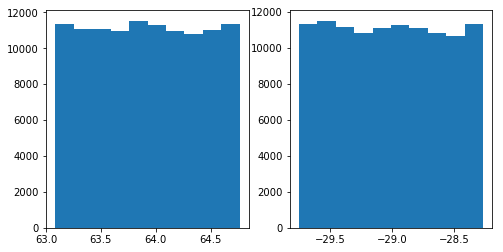

In [7]:
fig, axes = plt.subplots(1,2, figsize = (8,4))
_ = axes[0].hist(object_data['ra'])
_ = axes[1].hist(object_data['dec'])

Generate the images using the cutout code from Michael Wood-Vasey (https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/dm_butler_postage_stamps.ipynb) taking a random value in the ($ra,dec$) histograms:

In [9]:
ra_field, dec_field = 63.33948013921437, -28.970247263971835

for k, filter_k in enumerate (filters):
    if k == 0:
        cutout = cutout_img_dc2.cutout_coadd_ra_dec(butler_u, ra_field, dec_field, filter=filter_k, cutoutSideLength=imsize)
    else:
        cutout = cutout_img_dc2.cutout_coadd_ra_dec(butler_grizy, ra_field, dec_field, filter=filter_k, cutoutSideLength=imsize)

    radec = lsst.geom.SpherePoint(ra_field, dec_field, lsst.geom.degrees)
    xy = cutout.getWcs().skyToPixel(radec)  # returns a Point2D

    img[0,:,:,k]= cutout.image.array

Text(0.5, 1.0, 'field in $(gri)$ filters')

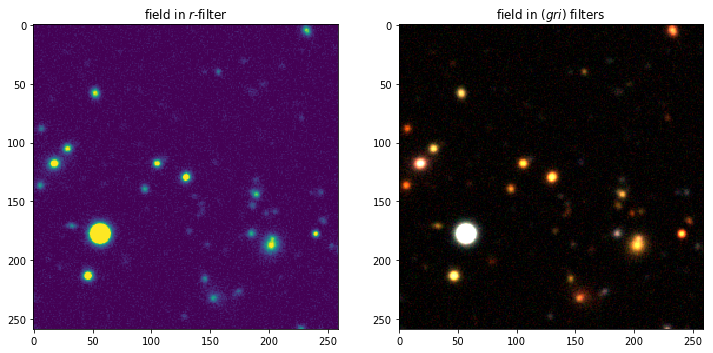

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (12,8))
axes[0].imshow(np.clip(img[0,:,:,2], a_min=0.0, a_max=1.))

bands = [3,2,1]
axes[1].imshow(np.clip(img[0][:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('field in $r$-filter')
axes[1].set_title('field in $(gri)$ filters')

### Retrieve stamps for galaxies in the field at magnitude below 24.5 in the $r$-band

Now we take only the $(ra, dec)$ limits from the field.

In [11]:
arcsec_to_deg = 0.00027 # One arcsecond is 0.00027 in (ra,dec) coordinates
lsst_pixel_scale = 0.2 # arcsecond

In [12]:
# Match the corresponding area for the truth catalog
max_ra = ra_field+int(imsize/2)*lsst_pixel_scale*arcsec_to_deg 
min_ra = ra_field-int(imsize/2)*lsst_pixel_scale*arcsec_to_deg
max_dec = dec_field+int(imsize/2)*lsst_pixel_scale*arcsec_to_deg
min_dec = dec_field-int(imsize/2)*lsst_pixel_scale*arcsec_to_deg

vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
native_filter = f'(healpix_pixel == {ipix[0]})'
for ipx in ipix:
    native_filter=native_filter+f' | (healpix_pixel == {ipx})'
pos_filters=[f'ra >= {min_ra}',f'ra <={max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

Now recover input information from the galaxies that are on the field.

In [13]:
# Define a mag cut for truth catalog 
truth_mag_filters = ['mag_r < '+str(mag_cut)]

# Load wanted quantities from truth catalog (https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md)
quantities = ['galaxy_id', 'ra', 'dec', 
              'redshift', 'redshift_true',
              'mag_r_lsst',
              'ellipticity_1_true', 'ellipticity_2_true',
              'convergence',
              'shear_1', 'shear_2']


truth_data = gc.get_quantities(quantities, filters=truth_mag_filters+pos_filters, 
                                      native_filters=native_filter)

Match the galaxies with the ones detected on the object catalog

In [14]:
# FoFCatalogMatching.match takes a dictionary of catalogs to match, a friends-of-friends linking length. 
# Because our "catalog" is not an astropy table or pandas dataframe, 
# `len(truth_coord)` won't give the actual length of the table
# so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.
results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_data, 'object': object_data},
    linking_lengths=0.1, # Linking length of 0.1 arcsecond, you can play around with the values!
    catalog_len_getter=lambda x: len(x['ra']),
)

In [15]:
# first we need to know which rows are from the truth catalog and which are from the object
truth_mask = results['catalog_key'] == 'truth'
object_mask = ~truth_mask

# then np.bincount will give up the number of id occurrences (like histogram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 1)))

truth_idx_gal = results['row_index'][one_to_one_group_mask & truth_mask]
object_idx_gal = results['row_index'][one_to_one_group_mask & object_mask]

id_ra_dec = Table.from_pandas(pd.DataFrame.from_dict(object_data))

In [16]:
print('There are '+str(len(truth_idx_gal))+' galaxies found on the image at a magnitude below 24.5 in the r-band. Extract stamps around these '+str(len(truth_idx_gal))+' galaxies and the corresponding parameters.')

There are 12 galaxies found on the image at a magnitude below 24.5 in the r-band. Extract stamps around these 12 galaxies and the corresponding parameters.


In [17]:
xy_list = []
e1 = []
e2 = []
hsm_e1 = []
hsm_e2 = []
shear1=[]
shear2=[]
redshift=[]
idx = []
blend = []
redshift_true=[]
convergence=[]
snr = []

img_field = np.zeros((len(truth_idx_gal),59,59,6))
psf_field = np.zeros((len(truth_idx_gal),59,59,6))
filters = ['u','g','r','i','z','y']

In [18]:
for i in range (len(truth_idx_gal)):
    first = id_ra_dec[object_idx_gal[i]]
    ra, dec = first['ra'], first['dec']

    for k, filter_k in enumerate (filters):
        if k == 0:
            cutout = cutout_img_dc2.cutout_coadd_ra_dec(butler_u, ra, dec, filter=filter_k, cutoutSideLength=59)
        else:
            cutout = cutout_img_dc2.cutout_coadd_ra_dec(butler_grizy, ra, dec, filter=filter_k, cutoutSideLength=59)

        radec = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
        xy = cutout.getWcs().skyToPixel(radec)  # returns a Point2D

        img_field[i,:,:,k]= cutout.image.array
        if (cutout.getPsf().computeKernelImage(xy).array.size != 3481):
            print('not taken into account')
            break
        else:
            psf_field[i,:,:,k]= cutout.getPsf().computeKernelImage(xy).array
    
    xy_list.append((xy.x,xy.y))
    idx.append(truth_data['galaxy_id'][truth_idx_gal[i]])
    e1.append(truth_data['ellipticity_1_true'][truth_idx_gal[i]])
    e2.append(truth_data['ellipticity_2_true'][truth_idx_gal[i]])
    hsm_e1.append(object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx_gal[i]])
    hsm_e2.append(object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx_gal[i]])
    shear1.append(truth_data['shear_1'][truth_idx_gal[i]])
    shear2.append(truth_data['shear_2'][truth_idx_gal[i]])
    redshift.append(truth_data['redshift'][truth_idx_gal[i]])
    blend.append(object_data['blendedness'][object_idx_gal[i]])
    snr.append(object_data['snr_r_cModel'][object_idx_gal[i]])
    redshift_true.append(truth_data['redshift_true'][truth_idx_gal[i]])
    convergence.append(truth_data['convergence'][truth_idx_gal[i]])

 Now let's take a look a these galaxies in the $r$-band:

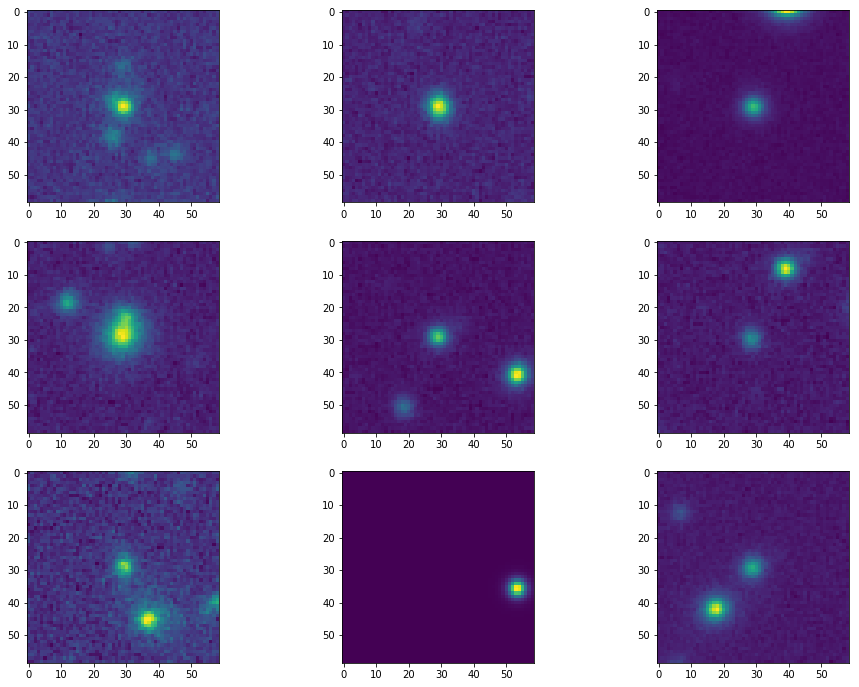

In [19]:
fig, axes = plt.subplots(3, 3, figsize = (16,12))
for i in range (3):
    for j in range (3):
        axes[i,j].imshow(img_field[i*3+j,:,:,2])

In RGB:

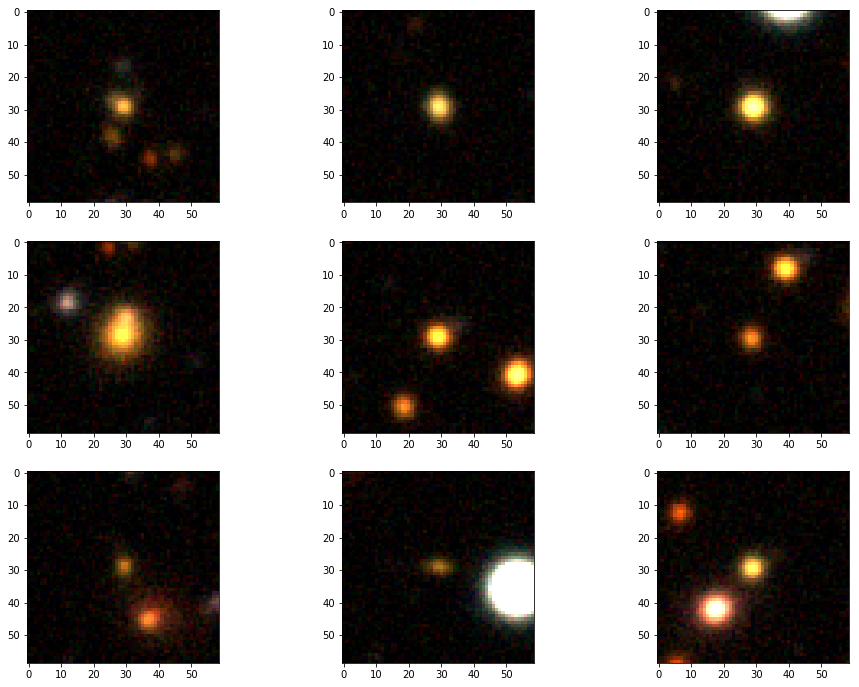

In [20]:
fig, axes = plt.subplots(3, 3, figsize = (16,12))
for i in range (3):
    for j in range (3):
        axes[i,j].imshow(np.clip(img_field[i*3+j][:,:,bands], a_min=0.0, a_max=1.))